In [122]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json


In [123]:


def add_hours_dam(df, start_hour, interval=48):
    for i in range(start_hour, start_hour+interval):
        start = str(i)
        df["DAM LMP_PRC_"+start+"_hours_ago"] = 0.0
    for i in range(len(df)-1, interval-1, -1):
        for j in range(start_hour, start_hour+interval):
            start = str(j)
            v = df['DAM LMP_PRC'].iloc[i-j,] 
            df.at[i, "DAM LMP_PRC_"+start+"_hours_ago"] =  v
    return df


def add_hours_rtm(df, start_hour, interval=48):
    for rtm in range(1, 13):
        for i in range(start_hour, start_hour+interval):
            start = str(i)
            df["RTM_"+str(rtm) +"_LMP_PRC_"+start+"_hours_ago"] = 0.0
        for i in range(len(df)-1, interval-1, -1):
            for j in range(start_hour, start_hour+interval):
                start = str(j)
                v = df[('RTM LMP_PRC', rtm)].iloc[i-j,] 
                df.at[i, "RTM_"+str(rtm) +"_LMP_PRC_"+start+"_hours_ago"] =  v
    return df

def add_hours_gap(df, start_hour, interval=48):
    for i in range(start_hour, start_hour+interval):
        start = str(i)
        df["GAP LMP_PRC_"+start+"_hours_ago"] = 0.0
    for i in range(len(df)-1, interval-1, -1):
        for j in range(start_hour, start_hour+interval):
            start = str(j)
            v = df['Gap'].iloc[i-j,] 
            df.at[i, "GAP LMP_PRC_"+start+"_hours_ago"] =  v
    return df

In [124]:
from sklearn.metrics import mean_absolute_error

def MAE(true, predicted):
    return mean_absolute_error(true, predicted)

def r_MAE(true, predicted):
    return mean_absolute_error(true, predicted)/abs(np.mean(true))

def MSE(true, predicted):
    squared_diff = np.square(true - predicted)
    return np.mean(squared_diff)

# Root Mean Square Error
def RMSE(true, predicted):
    squared_diff = np.square(true - predicted)    
    return np.sqrt(np.mean(squared_diff))

# R-squared, coefficient of determination
def R_squared(true, predicted):
    true      = np.array(true)
    predicted = np.array(predicted)
    sum_squared_diff = sum(np.square(true - predicted))
    variance  = sum(np.square(true - np.mean(true)))
    calc_r2   = 1 - (sum_squared_diff / variance)
    return calc_r2

def r_MSE(true, predicted):
    mse = MSE(true, predicted)
    return mse/np.mean(true)

def r_RMSE(true, predicted):
    rmse = RMSE(true, predicted)
    avg = 0
    for item in true:
        avg += abs(item)
    avg /= len(true)
    return rmse/avg


def MAPE(true, predicted): 
    return np.mean(np.abs((true - predicted) / true)) * 100

In [125]:
def Evaluate(Y_true, predictions):
    print('MAE '+str(MAE(Y_true, predictions)))
    print('RMSE '+str(RMSE(Y_true, predictions)))
    print('rMAE '+str(r_MAE(Y_true, predictions)*100) +'%')
    print('rRMSE '+str(r_RMSE(Y_true, predictions)*100)+'%')
    print('MAPE '+str(MAPE(Y_true, predictions))+'%')



In [126]:
df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
df['Gap'] = df['DAM LMP_PRC'] - df[('RTM LMP_PRC', 1)]
df = add_hours_dam(df, 1, 1)
df = add_hours_rtm(df, 1, 1)

Y_cols = ['Gap'] 
X_cols = [col for col in list(df) if col not in Y_cols+[
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_ENE_PRC', 1),
('RTM LMP_ENE_PRC', 2),
('RTM LMP_ENE_PRC', 3),
('RTM LMP_ENE_PRC', 4),
('RTM LMP_ENE_PRC', 5),
('RTM LMP_ENE_PRC', 6),
('RTM LMP_ENE_PRC', 7),
('RTM LMP_ENE_PRC', 8),
('RTM LMP_ENE_PRC', 9),
('RTM LMP_ENE_PRC', 10),
('RTM LMP_ENE_PRC', 11),
('RTM LMP_ENE_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
('RTM LMP_LOSS_PRC', 1),
('RTM LMP_LOSS_PRC', 2),
('RTM LMP_LOSS_PRC', 3),
('RTM LMP_LOSS_PRC', 4),
('RTM LMP_LOSS_PRC', 5),
('RTM LMP_LOSS_PRC', 6),
('RTM LMP_LOSS_PRC', 7),
('RTM LMP_LOSS_PRC', 8),
('RTM LMP_LOSS_PRC', 9),
('RTM LMP_LOSS_PRC', 10),
('RTM LMP_LOSS_PRC', 11),
('RTM LMP_LOSS_PRC', 12),
('RTM LMP_PRC', 1),
('RTM LMP_PRC', 2),
('RTM LMP_PRC', 3),
('RTM LMP_PRC', 4),
('RTM LMP_PRC', 5),
('RTM LMP_PRC', 6),
('RTM LMP_PRC', 7),
('RTM LMP_PRC', 8),
('RTM LMP_PRC', 9),
('RTM LMP_PRC', 10),
('RTM LMP_PRC', 11),
('RTM LMP_PRC', 12),
'DAM LMP_CONG_PRC',
'DAM LMP_GHG_PRC',
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
'DAM LMP_ENE_PRC',
'DAM LMP_LOSS_PRC',
'Actual_Demand',
('RTM LMP_PRC', 1),
'DAM LMP_PRC',]]
          
Y = df[Y_cols]
X = df[X_cols]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10615, shuffle=False, random_state=42)
ss1 = MinMaxScaler(feature_range=(0, 1))
X_train = ss1.fit_transform(X_train)
X_test = ss1.transform(X_test)
ss2 = MinMaxScaler(feature_range=(0, 1))
Y_train = ss2.fit_transform(Y_train)
Y_test = ss2.transform(Y_test)

In [127]:
features = len(list(X))

In [128]:
lookback_length = 24*30
batch_size = 1

In [129]:
# reshape input to be [samples, time steps, features]
# reshape input to be  [samples, time steps, features]
# X_train = np.reshape(X_train, (X_train.shape[0], lookback_length, features))
# testX = np.reshape(testX, (testX.shape[0],look_back, features))

In [130]:
X_train.shape

(14807, 73)

In [131]:
trainX.shape

(14905, 3, 147)

In [132]:
lookback_length = 7*24
batch_size = 1

In [133]:
from keras.preprocessing.sequence import TimeseriesGenerator
train_sequences  = TimeseriesGenerator(X_train,
                                       Y_train,
                                       length=lookback_length,
                                       batch_size=batch_size)
test_sequences = TimeseriesGenerator(X_test,
                                     Y_test,
                                     length=lookback_length,
                                     batch_size=batch_size)

In [134]:
model = Sequential()

model.add(LSTM(units=100, input_shape=(lookback_length, features)))

model.add(Dense(units=1))
model.compile(optimizer='rmsprop',loss='mean_squared_error')
model.fit_generator(train_sequences, validation_data=test_sequences, epochs=3, verbose=1)

Epoch 1/3
14639/14639 [==============================] - 964s 66ms/step - loss: 8.9699e-04 - val_loss: 1.1541e-05
Epoch 2/3
14639/14639 [==============================] - 1000s 68ms/step - loss: 5.9935e-04 - val_loss: 5.2054e-07
Epoch 3/3
14639/14639 [==============================] - 986s 67ms/step - loss: 5.9302e-04 - val_loss: 2.5554e-07


In [135]:
scaled_predictions = model.predict_generator(test_sequences)

In [136]:
scaled_predictions

array([[0.3946488 ],
       [0.39473754],
       [0.3954594 ],
       ...,
       [0.39804724],
       [0.39630854],
       [0.39567995]], dtype=float32)

In [137]:
Evaluate(Y_test[:-lookback_length], scaled_predictions)

MAE 0.006381904652119657
RMSE 0.015760147332146535
rMAE 1.6059611478625626%
rRMSE [3.96592956]%
MAPE 1.9373604926174959%


In [138]:
predictions = ss2.inverse_transform(scaled_predictions.reshape(-1, 1))

In [139]:
Y_true = []
temp = ss2.inverse_transform(Y_test)
for item in temp:
    Y_true.append(item[0])

In [140]:
Evaluate(Y_true[:-lookback_length], predictions)

MAE 24.02734537791343
RMSE 59.92382500068514
rMAE 321.5465370824593%
rRMSE 267.2248037156812%
MAPE 263.201091397324%


In [141]:
predictions

array([[-2.8422875],
       [-2.508146 ],
       [ 0.2096419],
       ...,
       [ 9.95259  ],
       [ 3.406538 ],
       [ 1.0399462]], dtype=float32)

In [142]:
Y_true[day:day+24]

[22.16139999999994,
 18.57152999999996,
 18.850350000000027,
 17.5994500000001,
 24.452690000000008,
 38.44951000000001,
 33.3605600000001,
 14.556180000000023,
 44.207479999999954,
 43.80703999999992,
 20.94023,
 5.966379999999996,
 4.566839999999992,
 7.951149999999903,
 7.346020000000027,
 3.569730000000058,
 6.988190000000075,
 0.2795399999999027,
 6.585409999999944,
 31.688209999999998,
 34.19482999999995,
 99.2789500000001,
 96.97053999999999,
 33.537159999999936]

In [143]:
Y_true[day+1:day+1+24]

[18.57152999999996,
 18.850350000000027,
 17.5994500000001,
 24.452690000000008,
 38.44951000000001,
 33.3605600000001,
 14.556180000000023,
 44.207479999999954,
 43.80703999999992,
 20.94023,
 5.966379999999996,
 4.566839999999992,
 7.951149999999903,
 7.346020000000027,
 3.569730000000058,
 6.988190000000075,
 0.2795399999999027,
 6.585409999999944,
 31.688209999999998,
 34.19482999999995,
 99.2789500000001,
 96.97053999999999,
 33.537159999999936,
 90.55068]

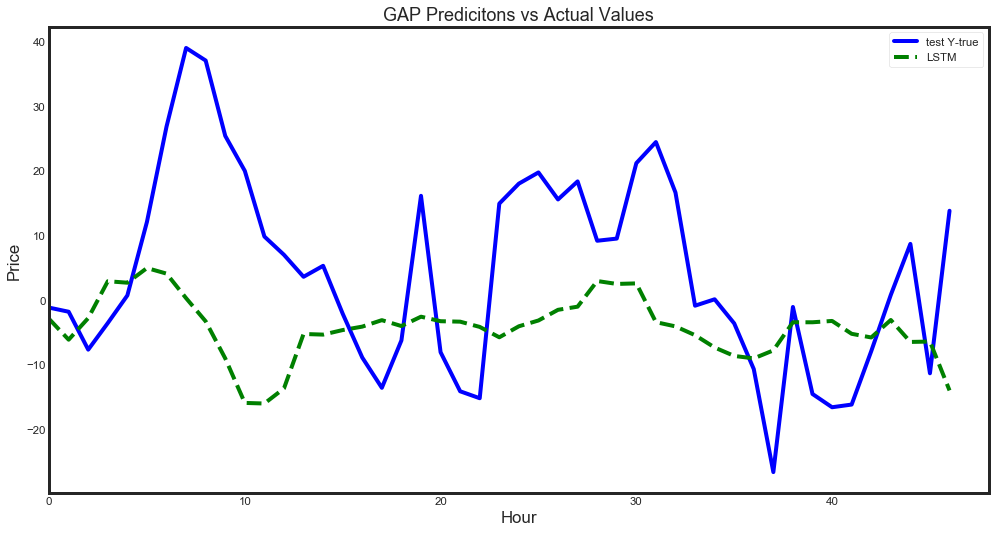

In [144]:
import datetime
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates



plt.figure(figsize=(15,8))
day = 25

plt.plot(Y_true[day*24+1:day*24+48],
         label='test Y-true',
         color='blue')
plt.plot(predictions[day*24+1:day*24+48],
         label='LSTM',
         color='green',linestyle='dashed')

# plt.plot(lasso_gap,
#          label='Lasso',
#          color='red',linestyle=':')
plt.legend()
plt.xlim(0,48)
plt.title('GAP Predicitons vs Actual Values', fontsize=18)
plt.xlabel('Hour')
plt.ylabel('Price')
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();

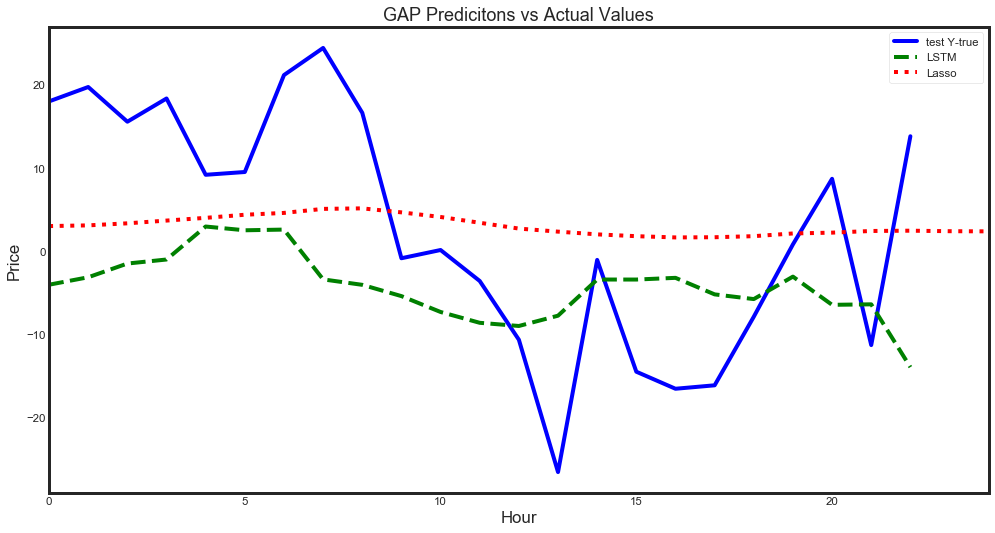

In [172]:
import datetime
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates



plt.figure(figsize=(15,8))
day = 26
plt.plot(Y_true[day*24+1:day*24+24],
         label='test Y-true',
         color='blue')
plt.plot(predictions[day*24+1:day*24+24],
         label='LSTM',
         color='green',linestyle='dashed')

plt.plot(lasso_gap,
         label='Lasso',
         color='red',linestyle=':')
plt.legend()
plt.xlim(0,24)
plt.title('GAP Predicitons vs Actual Values', fontsize=18)
plt.xlabel('Hour')
plt.ylabel('Price')
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();

In [147]:
datetime.date(2002, 3, 11)

datetime.date(2002, 3, 11)

In [148]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
maek = []
def best_day(predictions, Y_true):
    start_index = 0
    best = 10000
    cur = 0
    for i in range(0, len(predictions)-24, 24):
        cur = 0
        mae = mean_squared_error(predictions[i:i+24], Y_true[i:i+24])
        maek.append(mae)
        if mae < best:
            best = mae
            start_index = i
    return start_index

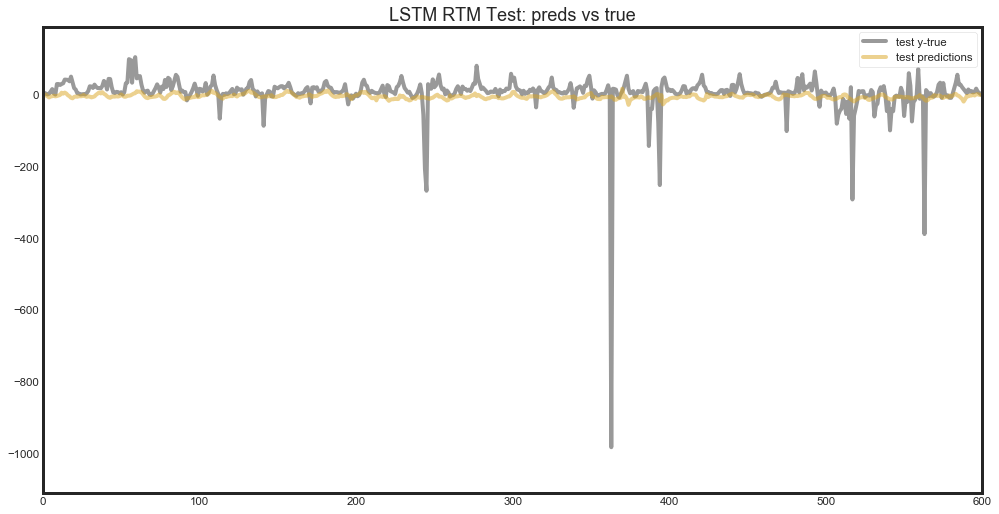

In [149]:

plt.figure(figsize=(15,8))

plt.plot(Y_true[:-lookback_length],
         label='test y-true',
         alpha = 0.8,
         color='grey')
plt.plot(predictions,
         label='test predictions',
         alpha = 0.5,
         color='goldenrod')
plt.legend()
plt.xlim(0, 600)
plt.title('LSTM RTM Test: preds vs true', fontsize=18)
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();

In [150]:
min(maek)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-150-9a491c945383>", line 1, in <module>
    min(maek)
ValueError: min() arg is an empty sequence

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\

ValueError: min() arg is an empty sequence

In [ ]:
len(Y_true)/24

In [ ]:
predictions[0:0+24]

In [ ]:
Y_true[0:0+24]

In [ ]:
df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
df['Gap'] = df['DAM LMP_PRC'] - df[('RTM LMP_PRC', 1)]
df = add_hours_dam(df, 1, 1)
df = add_hours_rtm(df, 12, 1)

In [ ]:
df = df.drop(['DAM LMP_CONG_PRC',
 'DAM LMP_ENE_PRC',
 'DAM LMP_GHG_PRC',
 'DAM LMP_LOSS_PRC',
 'DAM LMP_PRC',
 ('HASP LMP_CONG_PRC', 1),
 ('HASP LMP_CONG_PRC', 2),
 ('HASP LMP_CONG_PRC', 3),
 ('HASP LMP_CONG_PRC', 4),
 ('HASP LMP_ENE_PRC', 1),
 ('HASP LMP_ENE_PRC', 2),
 ('HASP LMP_ENE_PRC', 3),
 ('HASP LMP_ENE_PRC', 4),
 ('HASP LMP_GHG_PRC', 1),
 ('HASP LMP_LOSS_PRC', 1),
 ('HASP LMP_LOSS_PRC', 2),
 ('HASP LMP_LOSS_PRC', 3),
 ('HASP LMP_LOSS_PRC', 4),
 ('HASP LMP_PRC', 1),
 ('HASP LMP_PRC', 2),
 ('HASP LMP_PRC', 3),
 ('HASP LMP_PRC', 4),
 ('RTM LMP_CONG_PRC', 1),
 ('RTM LMP_CONG_PRC', 2),
 ('RTM LMP_CONG_PRC', 3),
 ('RTM LMP_CONG_PRC', 4),
 ('RTM LMP_CONG_PRC', 5),
 ('RTM LMP_CONG_PRC', 6),
 ('RTM LMP_CONG_PRC', 7),
 ('RTM LMP_CONG_PRC', 8),
 ('RTM LMP_CONG_PRC', 9),
 ('RTM LMP_CONG_PRC', 10),
 ('RTM LMP_CONG_PRC', 11),
 ('RTM LMP_CONG_PRC', 12),
 ('RTM LMP_ENE_PRC', 1),
 ('RTM LMP_ENE_PRC', 2),
 ('RTM LMP_ENE_PRC', 3),
 ('RTM LMP_ENE_PRC', 4),
 ('RTM LMP_ENE_PRC', 5),
 ('RTM LMP_ENE_PRC', 6),
 ('RTM LMP_ENE_PRC', 7),
 ('RTM LMP_ENE_PRC', 8),
 ('RTM LMP_ENE_PRC', 9),
 ('RTM LMP_ENE_PRC', 10),
 ('RTM LMP_ENE_PRC', 11),
 ('RTM LMP_ENE_PRC', 12),
 ('RTM LMP_GHG_PRC', 1),
 ('RTM LMP_GHG_PRC', 7),
 ('RTM LMP_LOSS_PRC', 1),
 ('RTM LMP_LOSS_PRC', 2),
 ('RTM LMP_LOSS_PRC', 3),
 ('RTM LMP_LOSS_PRC', 4),
 ('RTM LMP_LOSS_PRC', 5),
 ('RTM LMP_LOSS_PRC', 6),
 ('RTM LMP_LOSS_PRC', 7),
 ('RTM LMP_LOSS_PRC', 8),
 ('RTM LMP_LOSS_PRC', 9),
 ('RTM LMP_LOSS_PRC', 10),
 ('RTM LMP_LOSS_PRC', 11),
 ('RTM LMP_LOSS_PRC', 12),
 ('RTM LMP_PRC', 1),
 ('RTM LMP_PRC', 2),
 ('RTM LMP_PRC', 3),
 ('RTM LMP_PRC', 4),
 ('RTM LMP_PRC', 5),
 ('RTM LMP_PRC', 6),
 ('RTM LMP_PRC', 7),
 ('RTM LMP_PRC', 8),
 ('RTM LMP_PRC', 9),
 ('RTM LMP_PRC', 10),
 ('RTM LMP_PRC', 11),
 ('RTM LMP_PRC', 12)], axis=1)

In [ ]:
list(df)

In [ ]:

df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
df['Gap'] = df['DAM LMP_PRC'] - df[('RTM LMP_PRC', 1)]
df = add_hours_dam(df, 1, 1)
df = add_hours_rtm(df, 12, 1)

Y_cols = ['Gap'] 
X_cols = [col for col in list(df) if col not in Y_cols+[
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_ENE_PRC', 1),
('RTM LMP_ENE_PRC', 2),
('RTM LMP_ENE_PRC', 3),
('RTM LMP_ENE_PRC', 4),
('RTM LMP_ENE_PRC', 5),
('RTM LMP_ENE_PRC', 6),
('RTM LMP_ENE_PRC', 7),
('RTM LMP_ENE_PRC', 8),
('RTM LMP_ENE_PRC', 9),
('RTM LMP_ENE_PRC', 10),
('RTM LMP_ENE_PRC', 11),
('RTM LMP_ENE_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
('RTM LMP_LOSS_PRC', 1),
('RTM LMP_LOSS_PRC', 2),
('RTM LMP_LOSS_PRC', 3),
('RTM LMP_LOSS_PRC', 4),
('RTM LMP_LOSS_PRC', 5),
('RTM LMP_LOSS_PRC', 6),
('RTM LMP_LOSS_PRC', 7),
('RTM LMP_LOSS_PRC', 8),
('RTM LMP_LOSS_PRC', 9),
('RTM LMP_LOSS_PRC', 10),
('RTM LMP_LOSS_PRC', 11),
('RTM LMP_LOSS_PRC', 12),
('RTM LMP_PRC', 1),
('RTM LMP_PRC', 2),
('RTM LMP_PRC', 3),
('RTM LMP_PRC', 4),
('RTM LMP_PRC', 5),
('RTM LMP_PRC', 6),
('RTM LMP_PRC', 7),
('RTM LMP_PRC', 8),
('RTM LMP_PRC', 9),
('RTM LMP_PRC', 10),
('RTM LMP_PRC', 11),
('RTM LMP_PRC', 12),
'DAM LMP_CONG_PRC',
'DAM LMP_GHG_PRC',
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
'DAM LMP_ENE_PRC',
'DAM LMP_LOSS_PRC',
'Actual_Demand',
('RTM LMP_PRC', 1),
'DAM LMP_PRC',]]
          
Y = df[Y_cols]
X = df[X_cols]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10615, shuffle=False, random_state=42)
ss1 = MinMaxScaler(feature_range=(0, 1))
X_train = ss1.fit_transform(X_train)
X_test = ss1.transform(X_test)
ss2 = MinMaxScaler(feature_range=(0, 1))
Y_train = ss2.fit_transform(Y_train)
Y_test = ss2.transform(Y_test)

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
X_train = X_train.reshape(-1,1)

In [ ]:
dataset = df.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [ ]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from sklearn import preprocessing
%matplotlib inline

aa=[x for x in range(200)]
plt.figure(figsize=(20,12))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
test_predict

In [ ]:
Y_test

In [ ]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts

from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [ ]:

df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)

df = add_hours_dam(df, 1, 13)
df = add_hours_rtm(df, 12, 1)
df = df.drop([('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_ENE_PRC', 1),
('RTM LMP_ENE_PRC', 2),
('RTM LMP_ENE_PRC', 3),
('RTM LMP_ENE_PRC', 4),
('RTM LMP_ENE_PRC', 5),
('RTM LMP_ENE_PRC', 6),
('RTM LMP_ENE_PRC', 7),
('RTM LMP_ENE_PRC', 8),
('RTM LMP_ENE_PRC', 9),
('RTM LMP_ENE_PRC', 10),
('RTM LMP_ENE_PRC', 11),
('RTM LMP_ENE_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
('RTM LMP_LOSS_PRC', 1),
('RTM LMP_LOSS_PRC', 2),
('RTM LMP_LOSS_PRC', 3),
('RTM LMP_LOSS_PRC', 4),
('RTM LMP_LOSS_PRC', 5),
('RTM LMP_LOSS_PRC', 6),
('RTM LMP_LOSS_PRC', 7),
('RTM LMP_LOSS_PRC', 8),
('RTM LMP_LOSS_PRC', 9),
('RTM LMP_LOSS_PRC', 10),
('RTM LMP_LOSS_PRC', 11),
('RTM LMP_LOSS_PRC', 12),
('RTM LMP_PRC', 2),
('RTM LMP_PRC', 3),
('RTM LMP_PRC', 4),
('RTM LMP_PRC', 5),
('RTM LMP_PRC', 6),
('RTM LMP_PRC', 7),
('RTM LMP_PRC', 8),
('RTM LMP_PRC', 9),
('RTM LMP_PRC', 10),
('RTM LMP_PRC', 11),
('RTM LMP_PRC', 12),
'DAM LMP_CONG_PRC',
'DAM LMP_GHG_PRC',
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
'DAM LMP_ENE_PRC',
'DAM LMP_LOSS_PRC',
'Actual_Demand'], axis=1)
df['Gap'] = df['DAM LMP_PRC'] - df[('RTM LMP_PRC', 1)]
df = df.drop([('RTM LMP_PRC', 1), 'DAM LMP_PRC'], axis=1)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.head(13)

In [ ]:
len(list(df))

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = df.values

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[i for i in range(0, 85)]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 86))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -85:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -85:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
inv_y


In [ ]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
gap = df['DAM LMP_PRC'] - df[('RTM LMP_PRC', 1)]
df = add_hours_dam(df, 1, 1)
df = add_hours_rtm(df, 12, 1)

Y_cols = ['Gap'] 
X_cols = [col for col in list(df) if col not in Y_cols+[
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_ENE_PRC', 1),
('RTM LMP_ENE_PRC', 2),
('RTM LMP_ENE_PRC', 3),
('RTM LMP_ENE_PRC', 4),
('RTM LMP_ENE_PRC', 5),
('RTM LMP_ENE_PRC', 6),
('RTM LMP_ENE_PRC', 7),
('RTM LMP_ENE_PRC', 8),
('RTM LMP_ENE_PRC', 9),
('RTM LMP_ENE_PRC', 10),
('RTM LMP_ENE_PRC', 11),
('RTM LMP_ENE_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
('RTM LMP_LOSS_PRC', 1),
('RTM LMP_LOSS_PRC', 2),
('RTM LMP_LOSS_PRC', 3),
('RTM LMP_LOSS_PRC', 4),
('RTM LMP_LOSS_PRC', 5),
('RTM LMP_LOSS_PRC', 6),
('RTM LMP_LOSS_PRC', 7),
('RTM LMP_LOSS_PRC', 8),
('RTM LMP_LOSS_PRC', 9),
('RTM LMP_LOSS_PRC', 10),
('RTM LMP_LOSS_PRC', 11),
('RTM LMP_LOSS_PRC', 12),
('RTM LMP_PRC', 1),
('RTM LMP_PRC', 2),
('RTM LMP_PRC', 3),
('RTM LMP_PRC', 4),
('RTM LMP_PRC', 5),
('RTM LMP_PRC', 6),
('RTM LMP_PRC', 7),
('RTM LMP_PRC', 8),
('RTM LMP_PRC', 9),
('RTM LMP_PRC', 10),
('RTM LMP_PRC', 11),
('RTM LMP_PRC', 12),
'DAM LMP_CONG_PRC',
'DAM LMP_GHG_PRC',
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
'DAM LMP_ENE_PRC',
'DAM LMP_LOSS_PRC',
'Actual_Demand',
('RTM LMP_PRC', 1),
'DAM LMP_PRC',]]
df.insert(0, 'Gap', gap)

In [ ]:
Enrol_window = 150

print ('enrol window set to',Enrol_window )

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 2])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
df.iloc[2:(2 + 1), :]

In [ ]:
df.iloc[2,0]

In [ ]:

def load_data(datasetname, column, look_back, normalise_window):
    # A support function to help preparlook_backe datasets for an RNN/LSTM/GRU
 # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname

    dataX, dataY = [], []
    for i in range(len(data) - look_back - 1):
        a = data.iloc[i:(i +look_back), 1:]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])



    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # split into train and test sets
    train_size = int(len(data) * 0.67) 
    test_size = len(data) - train_size
    train, test = data[0:train_size, :], data[train_size:len(data), :]

    # reshape into X=t and Y=t+1
    look_back = 3
    trainX, trainY = create_dataset(train, look_back)  
    testX, testY = create_dataset(test, look_back)

    # reshape input to be  [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, 147))
    testX = numpy.reshape(testX, (testX.shape[0],look_back, 147))



#     sequence_length = seq_len + 1
#     result = []
#     for i in range(len(data) - sequence_length):
#         result.append(data[i: i + sequence_length])
    
# #     if normalise_window:
# # #         result = sc.fit_transform(result)
# #         result = normalise_windows(result)

#     result = np.array(result)

#     #Last 10% is used for validation test, first 90% for training
#     row = round(0.9 * result.shape[0])
#     train = result[:int(row), :]
#     np.random.shuffle(train)
#     x_train = train[:, :-1]
#     y_train = train[:, -1]
#     x_test = result[int(row):, :-1]
#     y_test = result[int(row):, -1]

#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [trainX, trainY, testX, testY]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        print(window)
        break
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

In [ ]:
feature_train, label_train, feature_test, label_test = load_data(df, 'Gap', 24*7, True)

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')


In [ ]:
model.fit(feature_train, label_train, batch_size=512, epochs=10, validation_data = (feature_test, label_test))

In [ ]:
lstm_gap = model.predict(feature_test)
plot_results(lstm_gap,label_test)

In [76]:
np.save('LSTM_GAP.npy', predictions) # save predictions

In [ ]:
lasso_gap = np.load('LASSO_GAP.npy')

In [ ]:
svr_gap = np.load('SVR_GAP.npy')

In [152]:
sns.set_style("white")
plt.figure(figsize=(12,8))
day = 22
plt.plot(label_test[day*24+1:day*24+24],
         label='Actual Values',
         color='black',
        linestyle='solid')
plt.plot(lstm_gap[day*24+1:day*24+24],
         label='LSTM',
         color='green',linestyle='dashed')

# plt.plot(lasso_gap[day*24+1:day*24+24],
#          label='Lasso',
#          color='red',linestyle='dotted')

# plt.plot(svr_gap[day*24:day*24+24],
#          label='SVR',
#          color='blue',linestyle='dashdot')

# plt.plot(svr_gap[day*24+1:day*24+24],
#          label='Lasso',
#          color='red',linestyle=':')
plt.legend()
plt.xlim(0,24)
plt.title('GAP Predicitons vs Actual Values', fontsize=18)
plt.xlabel('Hour')
plt.ylabel('Price')
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-152-06c05efb5bf1>", line 4, in <module>
    plt.plot(label_test[day*24+1:day*24+24],
NameError: name 'label_test' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Arashfs\Anaco

NameError: name 'label_test' is not defined

<Figure size 864x576 with 0 Axes>

In [153]:

plt.figure(figsize=(15,8))
day = 34
plt.plot(label_test,
         label='test y-true',
         alpha = 0.8,
         color='grey')
plt.plot(predicted_stock_price,
         label='test predictions',
         alpha = 0.5,
         color='goldenrod')
plt.legend()
plt.xlim(0, 600)
plt.title('LSTM RTM Test: preds vs true', fontsize=18)
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-153-8e29ccb54c21>", line 3, in <module>
    plt.plot(label_test,
NameError: name 'label_test' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Arashfs\Anaconda3\lib\site-packag

NameError: name 'label_test' is not defined

<Figure size 1080x576 with 0 Axes>

In [154]:
Evaluate(label_test, predicted_stock_price)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-154-bde72b6dfc19>", line 1, in <module>
    Evaluate(label_test, predicted_stock_price)
NameError: name 'label_test' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Arashfs\An

NameError: name 'label_test' is not defined

In [155]:
df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
gap = df['DAM LMP_PRC'] - df[('RTM LMP_PRC', 1)]
df = add_hours_dam(df, 1, 1)
df = add_hours_rtm(df, 12, 1)

Y_cols = ['Gap'] 
X_cols = [col for col in list(df) if col not in Y_cols+[
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_ENE_PRC', 1),
('RTM LMP_ENE_PRC', 2),
('RTM LMP_ENE_PRC', 3),
('RTM LMP_ENE_PRC', 4),
('RTM LMP_ENE_PRC', 5),
('RTM LMP_ENE_PRC', 6),
('RTM LMP_ENE_PRC', 7),
('RTM LMP_ENE_PRC', 8),
('RTM LMP_ENE_PRC', 9),
('RTM LMP_ENE_PRC', 10),
('RTM LMP_ENE_PRC', 11),
('RTM LMP_ENE_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
('RTM LMP_LOSS_PRC', 1),
('RTM LMP_LOSS_PRC', 2),
('RTM LMP_LOSS_PRC', 3),
('RTM LMP_LOSS_PRC', 4),
('RTM LMP_LOSS_PRC', 5),
('RTM LMP_LOSS_PRC', 6),
('RTM LMP_LOSS_PRC', 7),
('RTM LMP_LOSS_PRC', 8),
('RTM LMP_LOSS_PRC', 9),
('RTM LMP_LOSS_PRC', 10),
('RTM LMP_LOSS_PRC', 11),
('RTM LMP_LOSS_PRC', 12),
('RTM LMP_PRC', 1),
('RTM LMP_PRC', 2),
('RTM LMP_PRC', 3),
('RTM LMP_PRC', 4),
('RTM LMP_PRC', 5),
('RTM LMP_PRC', 6),
('RTM LMP_PRC', 7),
('RTM LMP_PRC', 8),
('RTM LMP_PRC', 9),
('RTM LMP_PRC', 10),
('RTM LMP_PRC', 11),
('RTM LMP_PRC', 12),
'DAM LMP_CONG_PRC',
'DAM LMP_GHG_PRC',
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
'DAM LMP_ENE_PRC',
'DAM LMP_LOSS_PRC',
'Actual_Demand',
('RTM LMP_PRC', 1),
'DAM LMP_PRC',]]
df.insert(0, 'Gap', gap)

In [156]:
df.head()

,Gap,hr_index,Actual_Demand,"(RT_Forecast_RTD, 1)","(RT_Forecast_RTD, 2)","(RT_Forecast_RTD, 3)","(RT_Forecast_RTD, 4)","(RT_Forecast_RTD, 5)","(RT_Forecast_RTD, 6)","(RT_Forecast_RTD, 7)","(RT_Forecast_RTD, 8)","(RT_Forecast_RTD, 9)","(RT_Forecast_RTD, 10)","(RT_Forecast_RTD, 11)","(RT_Forecast_RTD, 12)","(DAM RT_Forecast_RTPD, 1)","(DAM RT_Forecast_RTPD, 2)","(DAM RT_Forecast_RTPD, 3)","(DAM RT_Forecast_RTPD, 4)",Demand_Forecast_7Day_Ahead,Demand_Forecast_2Day_Ahead,Demand_Forecast_Day_Ahead,altimeter_set_1,Temperature,dewpoint,humidity,relative_humidity_set_1,windspeed,Wind Direction,wind_gust_set_1,weather_cond_code_set_1,cloud_layer_3_code_set_1,precip_accum_one_hour_set_1,cloud_layer_1_code_set_1,cloud_layer_2_code_set_1,visibility_set_1,ceiling_set_1,wind_chill_set_1d,pressure,sea_level_pressure_set_1d,heat_index_set_1d,weather_condition_set_1d,precipitation,precipitation_6,Year,Month,Day,Hour,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Relative Humidity,Solar Zenith Angle,Precipitable Water,DAM LMP_CONG_PRC,DAM LMP_ENE_PRC,DAM LMP_GHG_PRC,DAM LMP_LOSS_PRC,DAM LMP_PRC,"(HASP LMP_CONG_PRC, 1)","(HASP LMP_CONG_PRC, 2)","(HASP LMP_CONG_PRC, 3)","(HASP LMP_CONG_PRC, 4)","(HASP LMP_ENE_PRC, 1)","(HASP LMP_ENE_PRC, 2)","(HASP LMP_ENE_PRC, 3)","(HASP LMP_ENE_PRC, 4)","(HASP LMP_GHG_PRC, 1)","(HASP LMP_LOSS_PRC, 1)","(HASP LMP_LOSS_PRC, 2)","(HASP LMP_LOSS_PRC, 3)","(HASP LMP_LOSS_PRC, 4)","(HASP LMP_PRC, 1)","(HASP LMP_PRC, 2)","(HASP LMP_PRC, 3)","(HASP LMP_PRC, 4)","(RTM LMP_CONG_PRC, 1)","(RTM LMP_CONG_PRC, 2)","(RTM LMP_CONG_PRC, 3)","(RTM LMP_CONG_PRC, 4)","(RTM LMP_CONG_PRC, 5)","(RTM LMP_CONG_PRC, 6)","(RTM LMP_CONG_PRC, 7)","(RTM LMP_CONG_PRC, 8)","(RTM LMP_CONG_PRC, 9)","(RTM LMP_CONG_PRC, 10)","(RTM LMP_CONG_PRC, 11)","(RTM LMP_CONG_PRC, 12)","(RTM LMP_ENE_PRC, 1)","(RTM LMP_ENE_PRC, 2)","(RTM LMP_ENE_PRC, 3)","(RTM LMP_ENE_PRC, 4)","(RTM LMP_ENE_PRC, 5)","(RTM LMP_ENE_PRC, 6)","(RTM LMP_ENE_PRC, 7)","(RTM LMP_ENE_PRC, 8)","(RTM LMP_ENE_PRC, 9)","(RTM LMP_ENE_PRC, 10)","(RTM LMP_ENE_PRC, 11)","(RTM LMP_ENE_PRC, 12)","(RTM LMP_GHG_PRC, 1)","(RTM LMP_GHG_PRC, 7)","(RTM LMP_LOSS_PRC, 1)","(RTM LMP_LOSS_PRC, 2)","(RTM LMP_LOSS_PRC, 3)","(RTM LMP_LOSS_PRC, 4)","(RTM LMP_LOSS_PRC, 5)","(RTM LMP_LOSS_PRC, 6)","(RTM LMP_LOSS_PRC, 7)","(RTM LMP_LOSS_PRC, 8)","(RTM LMP_LOSS_PRC, 9)","(RTM LMP_LOSS_PRC, 10)","(RTM LMP_LOSS_PRC, 11)","(RTM LMP_LOSS_PRC, 12)","(RTM LMP_PRC, 1)","(RTM LMP_PRC, 2)","(RTM LMP_PRC, 3)","(RTM LMP_PRC, 4)","(RTM LMP_PRC, 5)","(RTM LMP_PRC, 6)","(RTM LMP_PRC, 7)","(RTM LMP_PRC, 8)","(RTM LMP_PRC, 9)","(RTM LMP_PRC, 10)","(RTM LMP_PRC, 11)","(RTM LMP_PRC, 12)",IsWeekday,IsWeekend,IsHoliday,DAM LMP_PRC_1_hours_ago,RTM_1_LMP_PRC_12_hours_ago,RTM_2_LMP_PRC_12_hours_ago,RTM_3_LMP_PRC_12_hours_ago,RTM_4_LMP_PRC_12_hours_ago,RTM_5_LMP_PRC_12_hours_ago,RTM_6_LMP_PRC_12_hours_ago,RTM_7_LMP_PRC_12_hours_ago,RTM_8_LMP_PRC_12_hours_ago,RTM_9_LMP_PRC_12_hours_ago,RTM_10_LMP_PRC_12_hours_ago,RTM_11_LMP_PRC_12_hours_ago,RTM_12_LMP_PRC_12_hours_ago
0,10.1389,12.0000,1902.0000,1866.0400,1862.3500,1865.5700,1863.1900,1864.5000,1886.3800,1882.3600,1879.7100,1890.8800,1890.8200,1887.4800,1904.5800,1842.4500,1856.2500,1842.3700,1851.2400,2003.2200,2014.3400,2007.0000,101286.8400,13.0000,5.5000,55.0000,87.3800,14.8000,249.6000,0.0000,0.0000,603.0000,0.0000,326.0000,426.0000,10.0000,1828.8000,0.0000,1014.3000,101288.4700,0.0000,0.0000,0.0000,0.0000,2017.0000,1.0000,1.0000,12.0000,91.0000,878.0000,577.0000,91.0000,878.0000,577.0000,1.0000,0.0000,75.1200,56.3700,1.3000,-7.9995,12.3457,0.0000,-0.0642,4.2820,-19.3196,-13.3369,-13.0043,-5.2550,7.0783,3.0819,3.0697,-6.2924,0.0000,-0.2088,-0.0897,-0.0859,0.1674,-12.4501,-10.3447,-10.0205,-11.3800,-28.7542,-28.7542,-25.5167,-26.1235,-22.3442,-20.0478,-19.9380,-12.9402,-12.9402,-15.4196,-15.4196,-21.6267,22.8972,22.8972,18.9040,19.6694,15.0053,12.1712,12.0357,3.3996,3.3996,-0.5941,-0.5941,8.8506,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000

In [157]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
values = df.values
scaled = scaler.fit_transform(values)
scaled[0]

array([0.39809673, 0.5       , 0.15275953, 0.41229342, 0.41114383,
       0.41157212, 0.40942572, 0.40939242, 0.41390947, 0.4186092 ,
       0.41803011, 0.42068074, 0.42022985, 0.4189475 , 0.42239989,
       0.40613104, 0.41239644, 0.40898294, 0.40728038, 0.2097006 ,
       0.18578991, 0.16328219, 0.98097741, 0.17845118, 0.60930233,
       0.53125   , 0.8738    , 0.24915825, 0.69335557, 0.        ,
       0.        , 0.24091091, 0.        , 0.13024371, 0.17019577,
       1.        , 0.24      , 0.        , 0.98237288, 0.98098712,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.52173913, 0.18383838, 0.87712288,
       0.54280339, 0.30434783, 0.87712288, 0.54280339, 0.11111111,
       0.        , 0.69464899, 0.28839655, 0.16870416, 0.04856002,
       0.02875071, 0.        , 0.23721656, 0.02706878, 0.61749855,
       0.21956803, 0.51343622, 0.63551091, 0.07534606, 0.07245904,
       0.11672934, 0.11776151, 0.        , 0.36814026, 0.52138

In [158]:
def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [159]:
timeSteps = 1

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147
0,0.3981,0.5000,0.1528,0.4123,0.4111,0.4116,0.4094,0.4094,0.4139,0.4186,0.4180,0.4207,0.4202,0.4189,0.4224,0.4061,0.4124,0.4090,0.4073,0.2097,0.1858,0.1633,0.9810,0.1785,0.6093,0.5312,0.8738,0.2492,0.6934,0.0000,0.0000,0.2409,0.0000,0.1302,0.1702,1.0000,0.2400,0.0000,0.9824,0.9810,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5217,0.1838,0.8771,0.5428,0.3043,0.8771,0.5428,0.1111,0.0000,0.6946,0.2884,0.1687,0.0486,0.0288,0.0000,0.2372,0.0271,0.6175,0.2196,0.5134,0.6355,0.0753,0.0725,0.1167,0.1178,0.0000,0.3681,0.5214,0.5045,0.3903,0.1227,0.0428,0.1867,0.2093,0.2904,0.2463,0.1900,0.2911,0.4526,0.4527,0.4604,0.4571,0.4600,0.2005,0.1780,0.1385,0.1540,0.1387,0.1390,0.1482,0.1439,0.1325,0.1314,0.1369,0.1351,0.1294,0.1296,0.1305,0.0000,0.0000,0.1289,0.3662,0.2718,0.2672,0.2777,0.1352,0.1409,0.1372,0.1205,0.1349,0.1783,0.1565,0.1419,0.1241,0.1215,0.1457,0.1185,0.1273,0.1292,0.1289,0.1453,0.1384,0.1401,0.1353,0.0000,1.0000,0.0000,0.0253,0.1451,0.1271,0.1248,0.1497,0.1225,0.1315,0.1333,0.1340,0.1503,0.1477,0.1494,0.1427,0.3964
1,0.3964,0.5417,0.1567,0.4204,0.4198,0.4195,0.4174,0.4168,0.4170,0.4227,0.4227,0.4257,0.4253,0.4252,0.4247,0.4117,0.4158,0.4158,0.4178,0.1996,0.1674,0.1601,0.9810,0.1785,0.6093,0.5312,0.8161,0.3098,0.6825,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,1.0000,0.0000,0.0000,0.9828,0.9810,0.0000,0.0769,0.0000,0.0000,0.0000,0.0000,0.0000,0.5652,0.3838,0.4006,0.3659,0.3110,0.8252,0.4722,0.8889,0.0000,0.7026,0.3131,0.1638,0.0485,0.0285,0.0000,0.2375,0.0269,0.6209,0.2212,0.5176,0.6364,0.0689,0.0629,0.1072,0.1146,0.0000,0.3706,0.5237,0.5071,0.3910,0.1198,0.0412,0.1829,0.2074,0.2974,0.2499,0.1914,0.2963,0.4532,0.4613,0.4640,0.4550,0.4561,0.2059,0.1858,0.1528,0.1506,0.1330,0.1373,0.1475,0.1492,0.1416,0.1371,0.1490,0.1444,0.1372,0.1247,0.1184,0.0000,0.0000,0.1289,0.3662,0.2718,0.2672,0.2777,0.1352,0.1409,0.1372,0.1205,0.1349,0.1783,0.1565,0.1452,0.1234,0.1213,0.1497,0.1226,0.1427,0.1368,0.1340,0.1469,0.1477,0.1428,0.1361,0.0000,1.0000,0.0000,0.0271,0.1452,0.1272,0.1288,0.1616,0.1257,0.1315,0.1337,0.1442,0.1601,0.1557,0.1596,0.1509,0.4014
2,0.4014,0.5833,0.1754,0.4233,0.4231,0.4239,0.4223,0.4223,0.4280,0.4349,0.4360,0.4408,0.4421,0.4411,0.4414,0.4204,0.4272,0.4290,0.4274,0.2018,0.1640,0.1722,0.9816,0.1785,0.6209,0.5312,0.8161,0.2795,0.6642,0.0000,0.0000,0.0000,0.0000,0.1542,0.2006,1.0000,0.0000,0.0000,0.9829,0.9816,0.0000,0.1538,0.0000,0.0000,0.0000,0.0000,0.0000,0.6087,0.2263,0.5405,0.3039,0.2742,0.7532,0.3528,0.8889,0.0000,0.7752,0.3557,0.1609,0.0497,0.0318,0.0000,0.2368,0.0293,0.6294,0.2226,0.5226,0.6396,0.0637,0.0623,0.1144,0.1333,0.0000,0.3704,0.5222,0.5052,0.3884,0.1226,0.0422,0.1930,0.2263,0.3067,0.2601,0.2061,0.3056,0.4612,0.4601,0.4642,0.4594,0.4663,0.2131,0.1896,0.1571,0.1281,0.1154,0.1183,0.1255,0.1258,0.1176,0.1246,0.1421,0.1505,0.1503,0.1532,0.1455,0.0000,0.0000,0.1289,0.3662,0.2718,0.2672,0.2777,0.1352,0.1409,0.1372,0.1205,0.1349,0.1783,0.1565,0.1382,0.1207,0.1185,0.1419,0.1163,0.1254,0.1286,0.1346,0.1615,0.1618,0.1655,0.1589,0.0000,1.0000,0.0000,0.0269,0.1451,0.1332,0.1319,0.1497,0.1225,0.1323,0.1354,0.1371,0.1509,0.1477,0.1494,0.1427,0.3983
3,0.3983,0.6250,0.1981,0.4400,0.4408,0.4419,0.4418,0.4431,0.4517,0.4601,0.4623,0.4537,0.4549,0.4564,0.4578,0.4376,0.4482,0.4536,0.4557,0.2206,0.1812,0.1948,0.9816,0.1448,0.6093,0.5104,0.8161,0.2189,0.6483,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,1.0000,0.0000,0.0000,0.9835,0.9816,0.0000,0.0769,0.0000,0.0000,0.0000,0.0000,0.0000,0.6522,0.1636,0.4056,0.1684,0.2107,0.6024,0.1957,0.2222,0.0400,0.7841,0.

In [160]:
features = df.shape[1]
train_hours = 550*24
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]



In [161]:
features

147

In [162]:
x_test.shape

(3365, 147)

In [163]:
y_train.shape

(13200,)

In [164]:
y_test.shape

(3365,)

In [165]:

#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 1, features )

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)


In [166]:
x_train.shape

(13200, 1, 147)

In [167]:
x_test.shape

(3365, 1, 147)

In [168]:

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape = ( timeSteps, x_train.shape[2]) ))
# model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

# model.fit(feature_train, label_train, batch_size=512, epochs=200, validation_data = (feature_test, label_test)
history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 10 , batch_size = 72, verbose = 1, shuffle = False)          
# model = Sequential()
# model.add( LSTM( 50, input_shape = ( timeSteps, x_train.shape[2]) ) )
# model.add( Dense(1) )

# model.compile( loss = "mse", optimizer = "adam")

# history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 50 , batch_size = 72, verbose = 1, shuffle = False)

Train on 13200 samples, validate on 3365 samples
Epoch 1/10
13200/13200 [==============================] - 2s 145us/step - loss: 0.0058 - val_loss: 4.1587e-04
Epoch 2/10
13200/13200 [==============================] - 1s 51us/step - loss: 6.5836e-04 - val_loss: 5.7750e-04
Epoch 3/10
13200/13200 [==============================] - 1s 51us/step - loss: 6.0292e-04 - val_loss: 7.9973e-04
Epoch 4/10
13200/13200 [==============================] - 1s 53us/step - loss: 5.7237e-04 - val_loss: 7.5737e-04
Epoch 5/10
13200/13200 [==============================] - 1s 51us/step - loss: 5.4982e-04 - val_loss: 5.4743e-04
Epoch 6/10
13200/13200 [==============================] - 1s 51us/step - loss: 5.3537e-04 - val_loss: 4.4674e-04
Epoch 7/10
13200/13200 [==============================] - 1s 52us/step - loss: 5.2397e-04 - val_loss: 3.9464e-04
Epoch 8/10
13200/13200 [==============================] - 1s 51us/step - loss: 5.1584e-04 - val_loss: 3.4926e-04
Epoch 9/10
13200/13200 [==========================

In [94]:
x_test.shape

(3365, 1, 147)

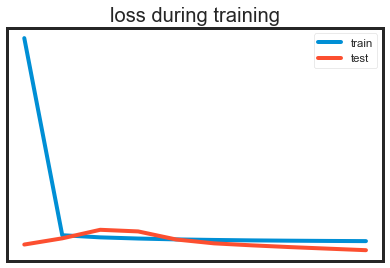

In [169]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

In [96]:
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[2]*x_test.shape[1])

In [170]:

#scale back the prediction to orginal scale
# y_pred = model.predict(x_test)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-features+1:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-features+1:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-170-20a0f3a4b7ac>", line 5, in <module>
    inv_new = np.concatenate( (y_pred, x_test[:,-features+1:] ) , axis =1)
ValueError: all the input arrays must have same number of dimensions

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lin

ValueError: all the input arrays must have same number of dimensions

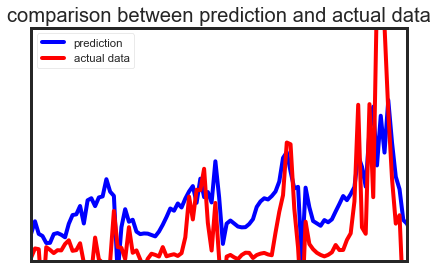

In [171]:

#plot the prediction with actual data

plt.plot(final_pred[:200], label = "prediction",c = "b")
plt.plot(actual_pred[:200],label = "actual data",c="r")
plt.xlim(0, 100)
plt.ylim(0, 300)
plt.yticks([])
plt.xticks([])
plt.title("comparison between prediction and actual data")
plt.legend()

In [99]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print ((mean_absolute_error(final_pred, actual_pred)))
print ((mean_squared_error(final_pred, actual_pred)))

53.20369743400283
6052.8281086207035


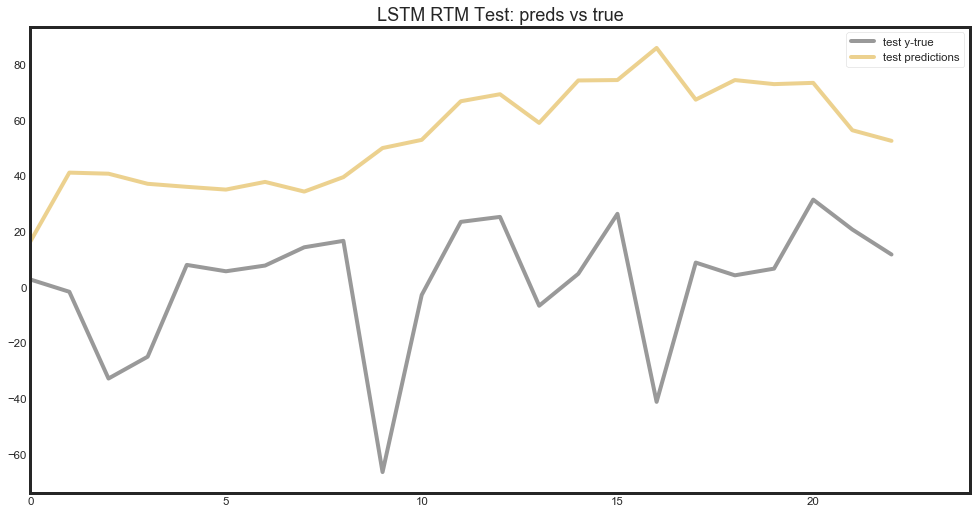

In [100]:

plt.figure(figsize=(15,8))
day = 31
plt.plot(actual_pred[day*24+1:day*24+24],
         label='test y-true',
         alpha = 0.8,
         color='grey')
plt.plot(final_pred[day*24+1:day*24+24],
         label='test predictions',
         alpha = 0.5,
         color='goldenrod')
plt.legend()
plt.xlim(0, 24)
plt.title('LSTM RTM Test: preds vs true', fontsize=18)
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();

In [101]:
final_pred[:10]

array([35.35900531, 50.83318534, 34.62037106, 31.90460264, 22.9145385 ,
       23.03986957, 34.3626401 , 35.67631621, 33.46366735, 30.19114621])

In [102]:
df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
gap = df['DAM LMP_PRC'] - df[('RTM LMP_PRC', 1)]
df = add_hours_dam(df, 1, 1)
df = add_hours_rtm(df, 12, 1)

Y_cols = ['Gap'] 
X_cols = [col for col in list(df) if col not in Y_cols+[
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_ENE_PRC', 1),
('RTM LMP_ENE_PRC', 2),
('RTM LMP_ENE_PRC', 3),
('RTM LMP_ENE_PRC', 4),
('RTM LMP_ENE_PRC', 5),
('RTM LMP_ENE_PRC', 6),
('RTM LMP_ENE_PRC', 7),
('RTM LMP_ENE_PRC', 8),
('RTM LMP_ENE_PRC', 9),
('RTM LMP_ENE_PRC', 10),
('RTM LMP_ENE_PRC', 11),
('RTM LMP_ENE_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
('RTM LMP_LOSS_PRC', 1),
('RTM LMP_LOSS_PRC', 2),
('RTM LMP_LOSS_PRC', 3),
('RTM LMP_LOSS_PRC', 4),
('RTM LMP_LOSS_PRC', 5),
('RTM LMP_LOSS_PRC', 6),
('RTM LMP_LOSS_PRC', 7),
('RTM LMP_LOSS_PRC', 8),
('RTM LMP_LOSS_PRC', 9),
('RTM LMP_LOSS_PRC', 10),
('RTM LMP_LOSS_PRC', 11),
('RTM LMP_LOSS_PRC', 12),
('RTM LMP_PRC', 1),
('RTM LMP_PRC', 2),
('RTM LMP_PRC', 3),
('RTM LMP_PRC', 4),
('RTM LMP_PRC', 5),
('RTM LMP_PRC', 6),
('RTM LMP_PRC', 7),
('RTM LMP_PRC', 8),
('RTM LMP_PRC', 9),
('RTM LMP_PRC', 10),
('RTM LMP_PRC', 11),
('RTM LMP_PRC', 12),
'DAM LMP_CONG_PRC',
'DAM LMP_GHG_PRC',
('HASP LMP_CONG_PRC', 1),
('HASP LMP_CONG_PRC', 2),
('HASP LMP_CONG_PRC', 3),
('HASP LMP_CONG_PRC', 4),
('HASP LMP_ENE_PRC', 1),
('HASP LMP_ENE_PRC', 2),
('HASP LMP_ENE_PRC', 3),
('HASP LMP_ENE_PRC', 4),
('HASP LMP_GHG_PRC', 1),
('HASP LMP_LOSS_PRC', 1),
('HASP LMP_LOSS_PRC', 2),
('HASP LMP_LOSS_PRC', 3),
('HASP LMP_LOSS_PRC', 4),
('HASP LMP_PRC', 1),
('HASP LMP_PRC', 2),
('HASP LMP_PRC', 3),
('HASP LMP_PRC', 4),
('RTM LMP_CONG_PRC', 1),
('RTM LMP_CONG_PRC', 2),
('RTM LMP_CONG_PRC', 3),
('RTM LMP_CONG_PRC', 4),
('RTM LMP_CONG_PRC', 5),
('RTM LMP_CONG_PRC', 6),
('RTM LMP_CONG_PRC', 7),
('RTM LMP_CONG_PRC', 8),
('RTM LMP_CONG_PRC', 9),
('RTM LMP_CONG_PRC', 10),
('RTM LMP_CONG_PRC', 11),
('RTM LMP_CONG_PRC', 12),
('RTM LMP_GHG_PRC', 1),
('RTM LMP_GHG_PRC', 7),
'DAM LMP_ENE_PRC',
'DAM LMP_LOSS_PRC',
'Actual_Demand',
('RTM LMP_PRC', 1),
'DAM LMP_PRC',]]
df.insert(0, 'Gap', gap)

In [103]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)



In [104]:
len(list(df))

147

In [105]:
# load the dataset
dataset = df.values

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, 147))
testX = numpy.reshape(testX, (testX.shape[0],look_back, 147))

In [106]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape = ( look_back, 147) ))
# model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(8, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

# model.fit(feature_train, label_train, batch_size=512, epochs=200, validation_data = (feature_test, label_test)
history =  model.fit( trainX,trainY, validation_data = (testX,testY), epochs = 10 , batch_size = 32, verbose = 1, shuffle = False)  

# model = Sequential()
# model.add(LSTM(4, input_shape=(look_back, 147)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# history= model.fit(trainX, trainY,validation_split=0.33, nb_epoch=200, batch_size=32)


Train on 14905 samples, validate on 1653 samples
Epoch 1/10
14905/14905 [==============================] - 6s 381us/step - loss: 0.0036 - val_loss: 3.9788e-04
Epoch 2/10
14905/14905 [==============================] - 3s 229us/step - loss: 6.1802e-04 - val_loss: 3.7506e-04
Epoch 3/10
14905/14905 [==============================] - 3s 228us/step - loss: 6.1435e-04 - val_loss: 3.7600e-04
Epoch 4/10
14905/14905 [==============================] - 3s 226us/step - loss: 6.0995e-04 - val_loss: 3.6017e-04
Epoch 5/10
14905/14905 [==============================] - 3s 220us/step - loss: 6.0571e-04 - val_loss: 3.4004e-04
Epoch 6/10
14905/14905 [==============================] - 3s 233us/step - loss: 6.0199e-04 - val_loss: 3.2252e-04
Epoch 7/10
14905/14905 [==============================] - 3s 233us/step - loss: 5.9875e-04 - val_loss: 3.0941e-04
Epoch 8/10
14905/14905 [==============================] - 3s 235us/step - loss: 5.9582e-04 - val_loss: 3.0073e-04
Epoch 9/10
14905/14905 [===================

In [107]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [108]:
trainPredict[:,0]

array([0.40196097, 0.4005571 , 0.4009962 , ..., 0.4033012 , 0.4042696 ,
       0.40612477], dtype=float32)

In [109]:

# Get something which has as many features as dataset
testPredict_extended = numpy.zeros((len(testPredict),147))
# Put the predictions there
testPredict_extended[:,0] = testPredict[:,0]
# Inverse transform it and select the 3rd column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,0]   


In [110]:
testY_extended = numpy.zeros((len(testY),147))
testY_extended[:,0]=testY
testY=scaler.inverse_transform(testY_extended)[:,0]

In [111]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 63.85 RMSE


In [112]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, 0] = testPredict

In [113]:
testPredict

array([49.70924499, 50.33735901, 49.90874244, ..., 35.65499759,
       33.23914857, 32.39403339])

In [114]:
testY

array([-0.04184,  7.44451, 22.77914, ..., 14.65368,  7.47426,  3.91056])

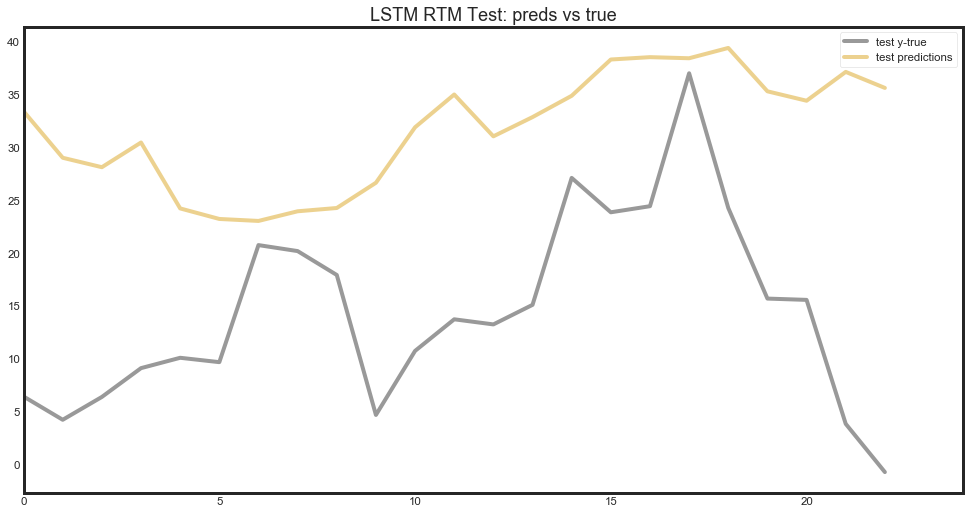

In [115]:

plt.figure(figsize=(15,8))
day = 60
plt.plot(testY[day*24+1:day*24+24],
         label='test y-true',
         alpha = 0.8,
         color='grey')
plt.plot(testPredict[day*24+1:day*24+24],
         label='test predictions',
         alpha = 0.5,
         color='goldenrod')
plt.legend()
plt.xlim(0, 24)
plt.title('LSTM RTM Test: preds vs true', fontsize=18)
# plt.savefig('../images/dam_RNN_12_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-116-5d8783fa02cc>", line 2, in <module>
    prediccion_entrenamiento,=plt.plot(trainPredictPlot[:,0],linestyle='--')
NameError: name 'trainPredictPlot' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Arashfs\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_

NameError: name 'trainPredictPlot' is not defined

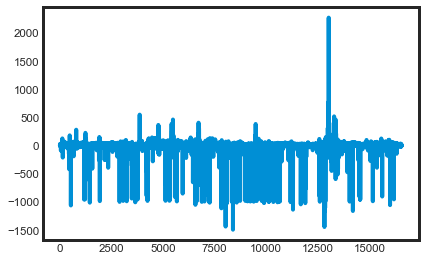

In [116]:

serie,=plt.plot(scaler.inverse_transform(dataset)[:,0])  
prediccion_entrenamiento,=plt.plot(trainPredictPlot[:,0],linestyle='--')  
prediccion_test,=plt.plot(testPredictPlot[:,0],linestyle='--')
plt.title('Consumo de agua')
plt.ylabel('cosumo (m3)')
plt.xlabel('dia')
plt.legend([serie,prediccion_entrenamiento,prediccion_test],['serie','entrenamiento','test'], loc='upper right')

In [ ]:
testX